In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import dt2int

from collections import namedtuple
from datetime import timedelta, datetime

from simglucose.patient.t1dpatient import T1DPatient

from simglucose.sensor.cgm import CGMSensor
from simglucose.simulation.env import T1DSimEnv
from simglucose.actuator.pump import InsulinPump
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.simulation.sim_engine import SimObj, sim
from simglucose.simulation.scenario import CustomScenario
from simglucose.controller.basal_bolus_ctrller import BBController

from scipy.integrate import solve_ivp

In [2]:
# better plots
sns.set_style('whitegrid')

# data structure for storing patient action
Action = namedtuple("patient_action", ['CHO', 'insulin'])
Observation = namedtuple("observation", ['Gsub'])

# inbuilt

In [3]:
p = T1DPatient.withName("adult#001")
basal = p._params.u2ss * p._params.BW / 6000

t = []
CHO = []
BG = []
while p.t < 1000:
    ins = basal
    carb = 0

    if p.t == 100:
        carb = 80
        ins = 80.0 / 6.0 + basal
    
    if p.t == 150:
        carb = 80
        ins = 80.0 / 12.0 + basal

    act = Action(insulin=ins, CHO=carb)
    t.append(p.t)
    CHO.append(act.CHO)
    BG.append(p.observation.Gsub)
    p.step(act)

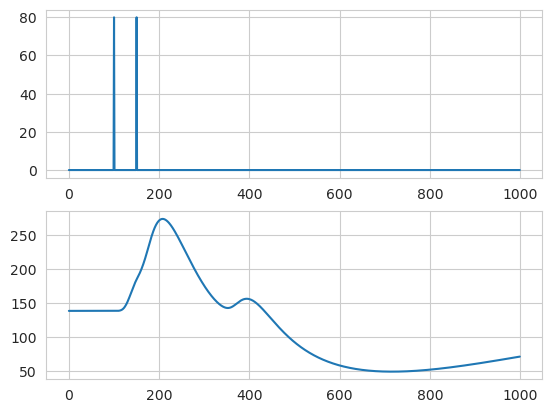

In [4]:
plt.subplot(211)
plt.plot(t, CHO, label='CHO')
plt.subplot(212)
plt.plot(t, BG, label='BG')
plt.show()

In [5]:
data = pd.read_csv("results/adult#001.csv")

# destructure data
data_t = data["Time"].map(lambda d: dt2int(d, fmt="%Y-%m-%d %H:%M:%S.%f")).to_numpy()
data_BG = data["BG"].to_numpy()
data_CGM = data["CGM"].to_numpy()
data_CHO = data["CHO"].to_numpy()
data_insulin = data["insulin"].to_numpy()

# normalize time
data_t -= data_t[0]

# scale down to minutes
data_t = data_t / 60.0

# clean
data_CHO = np.nan_to_num(data_CHO, nan=data_CHO[0])
data_insulin = np.nan_to_num(data_insulin, nan=data_insulin[0])

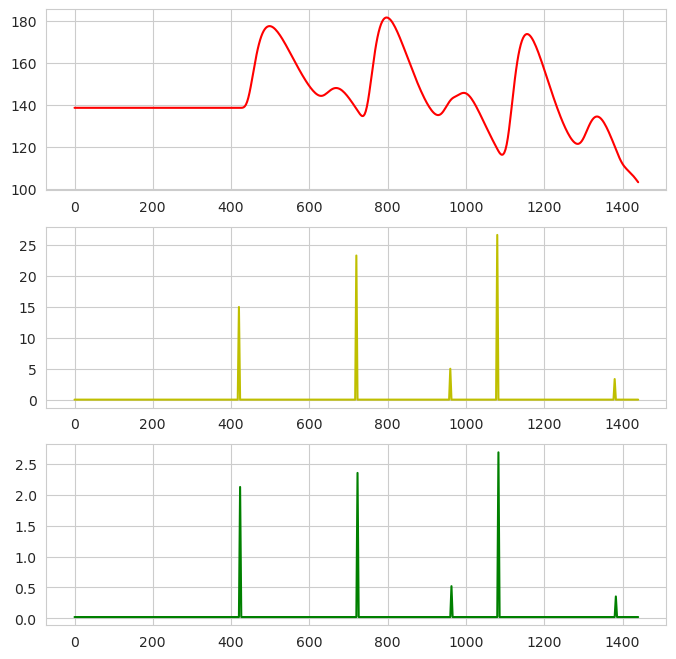

In [6]:
plt.figure(figsize=(8, 8))
plt.subplot(311)
plt.plot(data_t, data_BG, "r")
plt.subplot(312)
plt.plot(data_t, data_CHO, "y")
plt.subplot(313)
plt.plot(data_t, data_insulin, "g")
plt.show()

In [7]:
CHO_times = data_t[data_CHO > data_CHO[0]]
ins_times = data_t[data_insulin > data_insulin[0]]

In [8]:
p = T1DPatient.withName("adult#001")
basal = p._params.u2ss * p._params.BW / 6000

t = []
CHO = []
BG = []
insr = []
while p.t < data_t[-1]:
    ins = basal
    carb = 0

    if p.t in CHO_times:
        carb = 3 * data_CHO[data_t == p.t]

    if p.t in ins_times:
        ins = 3 * data_insulin[data_t == p.t]

    act = Action(insulin=ins, CHO=carb)
    t.append(p.t)
    CHO.append(act.CHO)
    BG.append(p.observation.Gsub)
    insr.append(act.insulin)
    p.step(act)

/home2/vishva.saravanan/miniconda3/envs/v/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


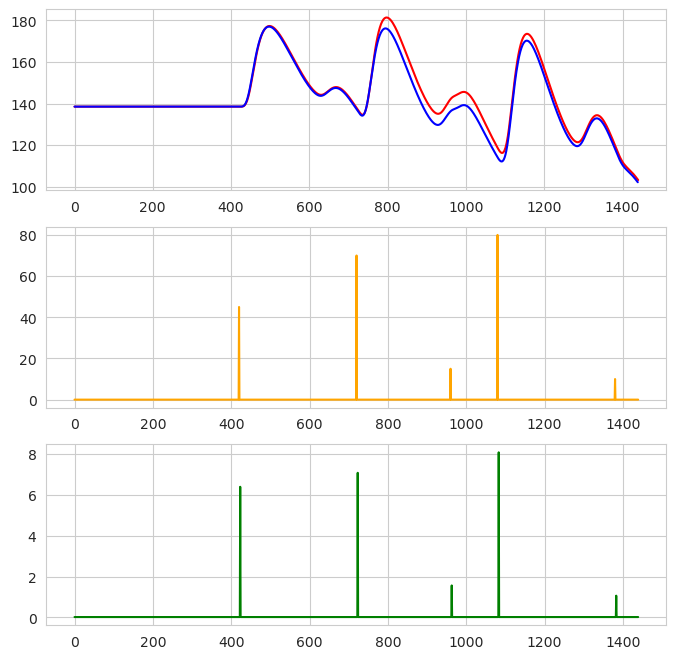

In [9]:
plt.figure(figsize=(8, 8))
plt.subplot(311)
plt.plot(data_t, data_BG, "r")
plt.plot(t, BG, "b")
plt.subplot(312)
plt.plot(t, CHO, "orange")
plt.subplot(313)
plt.plot(t, insr, "g")
plt.show()

In [61]:
SAMPLE_TIME = 1 # min
EAT_RATE = 5 # g/min CHO

_last_action = Action(CHO=0, insulin=0)
_last_foodtaken = 0
_is_eating = False
_planned_meal = 0

def ode(t, x, in_t, in_CHO, in_insulin, params):
    global _last_action, _is_eating, _planned_meal, _last_Qsto, _last_foodtaken

    # get current action
    t_mask = np.abs(in_t - t).argmin()
    action = Action(CHO=in_CHO[t_mask], insulin=in_insulin[t_mask])

    # basal = p._params.u2ss * p._params.BW / 6000
    # ins = basal
    # carb = 0

    # if data_CHO[t_mask] > data_CHO[0]:
    #     print(f"eating: {data_CHO[t_mask]}CHO @ {t}m")
    # carb = 3 * data_CHO[t_mask]

    # if data_insulin[t_mask] > data_insulin[0]:
    #     print(f"injecting: {data_insulin[t_mask]}u @ {t}m")
    # ins = 3 * data_insulin[t_mask]

    # action = Action(CHO=carb, insulin=ins)

    # meal = action.CHO
    # _planned_meal += meal
    # if _planned_meal > 0:
    #     to_eat = min(EAT_RATE, _planned_meal)
    #     _planned_meal -= to_eat
    #     _planned_meal = max(0, _planned_meal)
    # else:
    #     to_eat = 0

    # action = action._replace(CHO=to_eat)

    # detect eating and update last digestion amount
    # if action.CHO > 0 and _last_action.CHO <= 0:
    #     _last_Qsto = x[0] + x[1]
    #     _last_foodtaken = 0
    #     _is_eating = True

    # if _is_eating:
    #     _last_foodtaken += action.CHO # g

    # # detect eating ended
    # if action.CHO <= 0 and _last_action.CHO > 0:
    #     _is_eating = False

    # action = Action()

    # update last action
    _last_action = action

    # dynamics
    dxdt = np.zeros(13)
    d = action.CHO * 1000  # g -> mg
    insulin = action.insulin * 6000 / params.BW  # U/min -> pmol/kg/min
    basal = params.u2ss * params.BW / 6000  # U/min

    # glucose in the stomach
    qsto = x[0] + x[1]
    # NOTE: Dbar is in unit mg, hence last_foodtaken needs to be converted
    # from mg to g. See https://github.com/jxx123/simglucose/issues/41 for
    # details.
    Dbar = _last_Qsto + _last_foodtaken * 1000  # unit: mg

    # Stomach solid
    dxdt[0] = -params.kmax * x[0] + d

    if Dbar > 0:
        aa = 5 / 2 / (1 - params.b) / Dbar
        cc = 5 / 2 / params.d / Dbar
        kgut = params.kmin + (params.kmax - params.kmin) / 2 * (
            np.tanh(aa * (qsto - params.b * Dbar)) -
            np.tanh(cc * (qsto - params.d * Dbar)) + 2)
    else:
        kgut = params.kmax

    # stomach liquid
    dxdt[1] = params.kmax * x[0] - x[1] * kgut

    # intestine
    dxdt[2] = kgut * x[1] - params.kabs * x[2]

    # Rate of appearance
    Rat = params.f * params.kabs * x[2] / params.BW
    # Glucose Production
    EGPt = params.kp1 - params.kp2 * x[3] - params.kp3 * x[8]
    # Glucose Utilization
    Uiit = params.Fsnc

    # renal excretion
    if x[3] > params.ke2:
        Et = params.ke1 * (x[3] - params.ke2)
    else:
        Et = 0

    # glucose kinetics
    # plus dextrose IV injection input u[2] if needed
    dxdt[3] = max(EGPt, 0) + Rat - Uiit - Et - \
        params.k1 * x[3] + params.k2 * x[4]
    dxdt[3] = (x[3] >= 0) * dxdt[3]

    Vmt = params.Vm0 + params.Vmx * x[6]
    Kmt = params.Km0
    Uidt = Vmt * x[4] / (Kmt + x[4])
    dxdt[4] = -Uidt + params.k1 * x[3] - params.k2 * x[4]
    dxdt[4] = (x[4] >= 0) * dxdt[4]

    # insulin kinetics
    dxdt[5] = -(params.m2 + params.m4) * x[5] + params.m1 * x[9] + params.ka1 * \
        x[10] + params.ka2 * x[11]  # plus insulin IV injection u[3] if needed
    It = x[5] / params.Vi
    dxdt[5] = (x[5] >= 0) * dxdt[5]

    # insulin action on glucose utilization
    dxdt[6] = -params.p2u * x[6] + params.p2u * (It - params.Ib)

    # insulin action on production
    dxdt[7] = -params.ki * (x[7] - It)

    dxdt[8] = -params.ki * (x[8] - x[7])

    # insulin in the liver (pmol/kg)
    dxdt[9] = -(params.m1 + params.m30) * x[9] + params.m2 * x[5]
    dxdt[9] = (x[9] >= 0) * dxdt[9]

    # subcutaneous insulin kinetics
    dxdt[10] = insulin - (params.ka1 + params.kd) * x[10]
    dxdt[10] = (x[10] >= 0) * dxdt[10]

    dxdt[11] = params.kd * x[10] - params.ka2 * x[11]
    dxdt[11] = (x[11] >= 0) * dxdt[11]

    # subcutaneous glucose
    dxdt[12] = (-params.ksc * x[12] + params.ksc * x[3])
    dxdt[12] = (x[12] >= 0) * dxdt[12]

    # if action.insulin > basal:
    #     print('t = {}, injecting insulin: {}'.format(t, action.insulin))

    return dxdt

In [44]:
# load parameters
orig_params = pd.read_csv("../simglucose/simglucose/params/vpatient_params.csv")
params = orig_params.loc[orig_params["Name"] == "adult#001"].squeeze()

In [45]:
# timespan
t_span = (data_t[0], data_t[-1])
t_eval = data_t

In [46]:
# initial conditions
u0 = params.iloc[2:15].to_numpy()
_last_Qsto = u0[0] + u0[1]

In [47]:
sol = solve_ivp(ode, t_span, u0, t_eval=t_eval, args=(data_t, data_CHO, data_insulin, params))

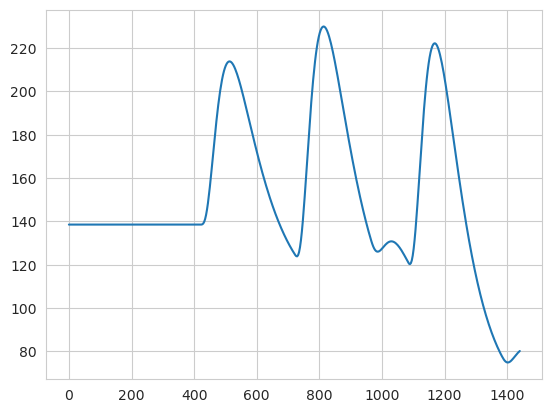

In [48]:
plt.plot(sol.t, sol.y[12] / params.Vg)

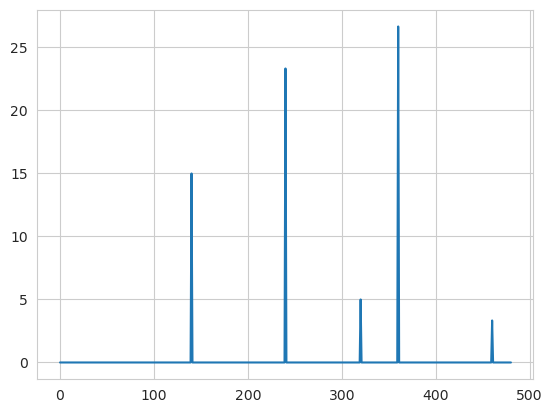

In [49]:
plt.plot(data_CHO)
plt.show()

In [50]:
data_CHO_cont = []

i = 0
while i < len(data_CHO):
    if data_CHO[i] > data_CHO[0]:
        for _ in range(int(3 * data_CHO[i] / EAT_RATE)):
            data_CHO_cont.append(EAT_RATE / 3)
            i += 1
    else:
        data_CHO_cont.append(data_CHO[i])
        i += 1

data_CHO_cont = np.array(data_CHO_cont)

In [51]:
data_CHO_cont.shape

(481,)

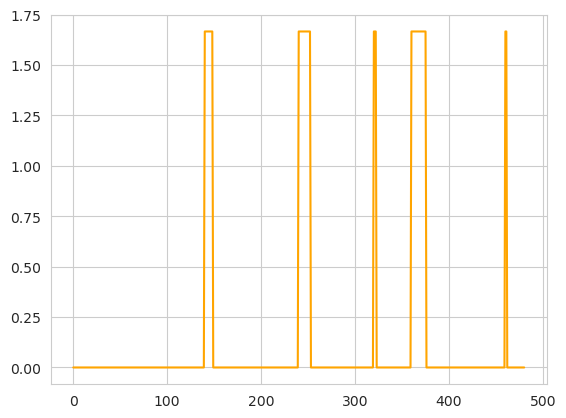

In [52]:
plt.plot(data_CHO_cont, "orange")
plt.show()

In [53]:
data_insulin_cont = []

i = 0
while i < len(data_insulin):
    if data_insulin[i] > data_insulin[0]:
        for _ in range(int(3 * data_insulin[i])):
            data_insulin_cont.append(1 / 3)
            i += 1
    else:
        data_insulin_cont.append(data_insulin[i])
        i += 1

data_insulin_cont = np.array(data_insulin_cont)

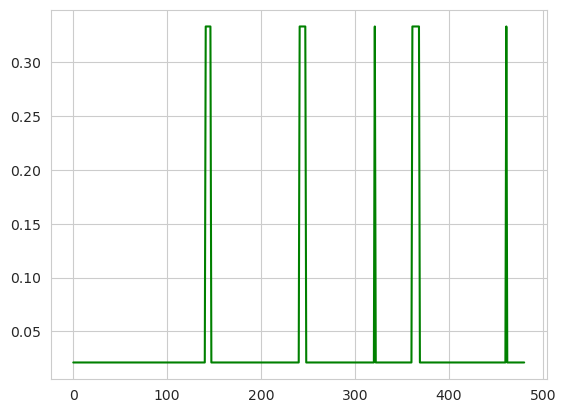

In [54]:
plt.plot(data_insulin_cont, "g")
plt.show()

In [55]:
sol = solve_ivp(ode, t_span, u0, t_eval=t_eval, args=(data_t, data_CHO_cont, data_insulin_cont, params))

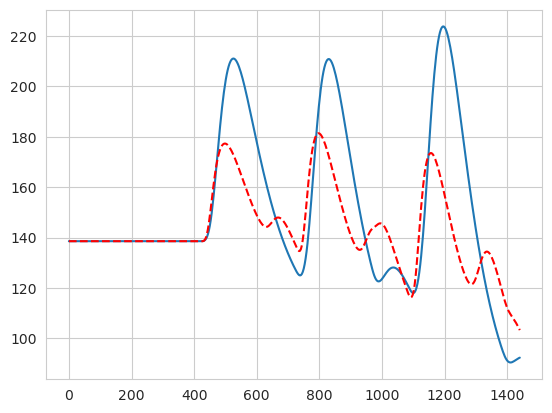

In [56]:
plt.plot(sol.t, sol.y[12] / params.Vg)
plt.plot(data_t, data_BG, "r--")
plt.show()

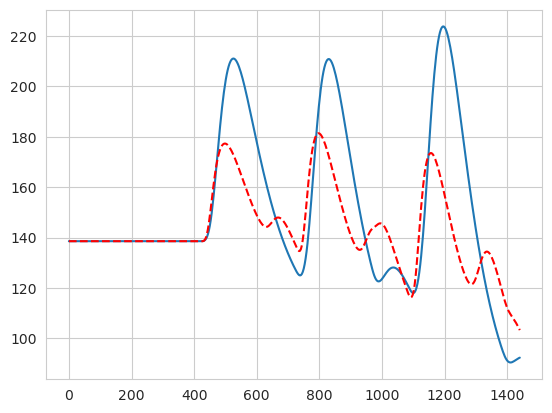

In [60]:
plt.plot(sol.t, sol.y[12] / params.Vg)
plt.plot(data_t, data_BG, "r--")
plt.show()

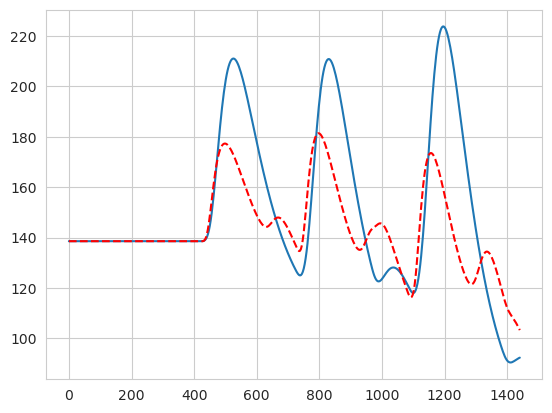

In [62]:
plt.plot(sol.t, sol.y[12] / params.Vg)
plt.plot(data_t, data_BG, "r--")
plt.show()